In [3]:
import tensorflow as tf

In [4]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,\
    Dropout, Dense, Input, concatenate, ZeroPadding2D,  \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, add, Activation, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall, FalseNegatives, FalsePositives,TrueNegatives,TruePositives, CategoricalCrossentropy
from tensorflow.keras.models import load_model

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import math  


import os
import numpy as np                                                                                                                                                                                                                                                                                                                                    
import matplotlib.pyplot as plt
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [5]:
train_dir = 'data_tr'
validate_dir = 'data_vl'
test_dir = 'data_ts'

num_of_train = 0
num_of_validate = 0
num_of_test = 0
for label in os.listdir(train_dir):
    for i in os.listdir(os.path.join(train_dir,label)):
        num_of_train+=1

for label in os.listdir(validate_dir):
    for i in os.listdir(os.path.join(validate_dir,label)):
        num_of_validate+=1

for label in os.listdir(test_dir):
    for i in os.listdir(os.path.join(test_dir,label)):
        num_of_test+=1

print(f"Total training sample:{num_of_train}\n",f"Total validating sample:{num_of_validate}\n",f"Total test sample:{num_of_test}")

Total training sample:427
 Total validating sample:120
 Total test sample:201


In [6]:
IMG_SIZE = (256,256)
batch_size = 8
epoch = 50
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)  

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=IMG_SIZE,
                                                           )

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validate_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE,
                                                              )

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=True,
                                                              target_size=IMG_SIZE,
                                                              )

Found 426 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


In [29]:
sample_test_images, labels = next(test_data_gen)
print(labels[0:10])
sample_test_images.shape
labels.shape

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


(8, 2)

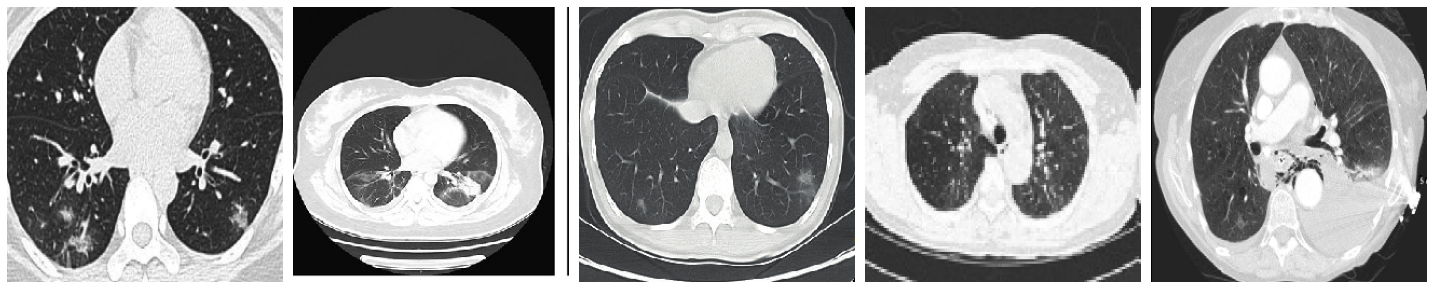

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [30]:
def plotImages(images_arr,labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(labels)
    

plotImages(sample_test_images[:5],labels[:5])

In [90]:
def residual_module(layer_in, n_filters,seq_strides=2,short_cut_stride=2):
    merge_input = layer_in
    x = Conv2D(n_filters, (3,3), strides=seq_strides, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(layer_in)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    short_cut = Conv2D(n_filters, (1,1), strides=short_cut_stride, padding='same', kernel_initializer='he_normal',kernel_regularizer=l2())(merge_input)
    short_cut = BatchNormalization(axis=3)(short_cut)
    short_cut = Activation('linear')(short_cut)
    # add filters, assumes filters/channels last
    layer_out = add([x, short_cut])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

input_layer = Input(shape=(256,256,3))
x = residual_module(input_layer,128)
x = residual_module(x,16)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = residual_module(x,16)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2())(x)
output = Dense(2,activation='sigmoid')(x)

largecovidcnn = Model(inputs=input_layer,outputs=output)
largecovidcnn.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 128, 128 3584        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 128, 128, 128 512         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 128, 128, 128 512         conv2d_42[0][0]                  
______________________________________________________________________________________

In [101]:
plot_model(largecovidcnn, show_shapes=True, to_file='largecovidcnn.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [103]:
import pydot
plot_model(largecovidcnn, show_shapes=True, to_file='largecovidcnn.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [106]:
initial_lrate = 0.00008


def decay(epoch, steps=10):
    initial_lrate = 0.0008
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


opt = Adam(lr=initial_lrate)
lr_sc = LearningRateScheduler(decay, verbose=1)


largecovidcnn.compile(optimizer=opt,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy',AUC(),Precision(),Recall()])

In [93]:
checkpoint = ModelCheckpoint("covid-19_large.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, mode='auto')
callback = [checkpoint,lr_sc]
hist = largecovidcnn.fit_generator(generator=train_data_gen, validation_data= test_data_gen, epochs=epoch,callbacks=callback)



Epoch 00001: LearningRateScheduler reducing learning rate to 0.0008.
Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 16.5546 - accuracy: 0.6080 - auc_7: 0.6637 - precision_7: 0.6163 - recall_7: 0.6221
Epoch 00001: val_accuracy improved from -inf to 0.47761, saving model to covid-19_large.h5
54/54 [==============================] - 98s 2s/step - loss: 16.5546 - accuracy: 0.6080 - auc_7: 0.6637 - precision_7: 0.6163 - recall_7: 0.6221 - val_loss: 15.8706 - val_accuracy: 0.4776 - val_auc_7: 0.5819 - val_precision_7: 0.4776 - val_recall_7: 0.4776

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008.
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 14.2881 - accuracy: 0.6526 - auc_7: 0.6845 - precision_7: 0.6224 - recall_7: 0.6385
Epoch 00002: val_accuracy improved from 0.47761 to 0.54726, saving model to covid-19_large.h5
54/54 [==============================] - 99s 2s/step - loss: 14.2881 - accuracy: 0.6526 - auc_7: 0.6845 - precisio


Epoch 00016: LearningRateScheduler reducing learning rate to 0.00073728.
Epoch 16/50
54/54 [==============================] - ETA: 0s - loss: 2.7149 - accuracy: 0.7136 - auc_7: 0.8084 - precision_7: 0.7123 - recall_7: 0.7207
Epoch 00016: val_accuracy did not improve from 0.61194
54/54 [==============================] - 98s 2s/step - loss: 2.7149 - accuracy: 0.7136 - auc_7: 0.8084 - precision_7: 0.7123 - recall_7: 0.7207 - val_loss: 2.8531 - val_accuracy: 0.5970 - val_auc_7: 0.6410 - val_precision_7: 0.5931 - val_recall_7: 0.6020

Epoch 00017: LearningRateScheduler reducing learning rate to 0.00073728.
Epoch 17/50
54/54 [==============================] - ETA: 0s - loss: 2.5565 - accuracy: 0.6948 - auc_7: 0.7572 - precision_7: 0.6967 - recall_7: 0.6901
Epoch 00017: val_accuracy did not improve from 0.61194
54/54 [==============================] - 104s 2s/step - loss: 2.5565 - accuracy: 0.6948 - auc_7: 0.7572 - precision_7: 0.6967 - recall_7: 0.6901 - val_loss: 2.7710 - val_accuracy: 0.4


Epoch 00031: LearningRateScheduler reducing learning rate to 0.0007077887999999999.
Epoch 31/50
54/54 [==============================] - ETA: 0s - loss: 1.2238 - accuracy: 0.6995 - auc_7: 0.7591 - precision_7: 0.6963 - recall_7: 0.6995
Epoch 00031: val_accuracy did not improve from 0.70647
54/54 [==============================] - 96s 2s/step - loss: 1.2238 - accuracy: 0.6995 - auc_7: 0.7591 - precision_7: 0.6963 - recall_7: 0.6995 - val_loss: 1.3231 - val_accuracy: 0.5622 - val_auc_7: 0.6466 - val_precision_7: 0.5600 - val_recall_7: 0.5572

Epoch 00032: LearningRateScheduler reducing learning rate to 0.0006794772479999999.
Epoch 32/50
54/54 [==============================] - ETA: 0s - loss: 1.1261 - accuracy: 0.7512 - auc_7: 0.8160 - precision_7: 0.7541 - recall_7: 0.7559
Epoch 00032: val_accuracy improved from 0.70647 to 0.72637, saving model to covid-19_large.h5
54/54 [==============================] - 96s 2s/step - loss: 1.1261 - accuracy: 0.7512 - auc_7: 0.8160 - precision_7: 0.75


Epoch 00046: LearningRateScheduler reducing learning rate to 0.0006522981580799999.
Epoch 46/50
54/54 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.7653 - auc_7: 0.8287 - precision_7: 0.7658 - recall_7: 0.7676
Epoch 00046: val_accuracy did not improve from 0.78109
54/54 [==============================] - 92s 2s/step - loss: 0.8219 - accuracy: 0.7653 - auc_7: 0.8287 - precision_7: 0.7658 - recall_7: 0.7676 - val_loss: 1.2345 - val_accuracy: 0.4925 - val_auc_7: 0.6142 - val_precision_7: 0.4925 - val_recall_7: 0.4925

Epoch 00047: LearningRateScheduler reducing learning rate to 0.0006522981580799999.
Epoch 47/50
54/54 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.7300 - auc_7: 0.8196 - precision_7: 0.7300 - recall_7: 0.7300
Epoch 00047: val_accuracy did not improve from 0.78109
54/54 [==============================] - 91s 2s/step - loss: 0.8203 - accuracy: 0.7300 - auc_7: 0.8196 - precision_7: 0.7300 - recall_7: 0.7300 - val_loss: 1.048

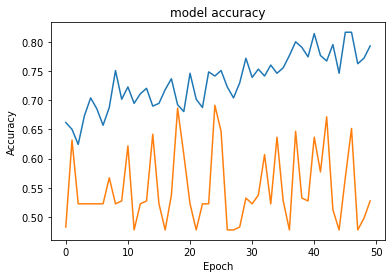

In [141]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

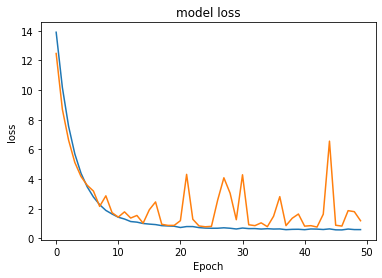

In [142]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")

plt.show()

In [164]:
model = load_model('covid-19_large.h5')

In [165]:
model_metrics = model.evaluate_generator(test_data_gen,verbose=1)

26/26 [==============================] - 5s 206ms/step - loss: 1.0145 - accuracy: 0.7811 - auc_7: 0.7967 - precision_7: 0.7811 - recall_7: 0.7811


In [166]:
f1_score = 2*( (model_metrics[3]*model_metrics[4]) / (model_metrics[3]+model_metrics[4]) )

In [167]:

print(f"Accuracy on test set: {round(model_metrics[1]*100,2)}%")
print(f"ROC(Receiver Operation Characteristic) AUC(Area Under Curve): {model_metrics[2]}")
print(f"Precision: {round(model_metrics[3]*100,2)}%")
print(f"Recall: {round(model_metrics[4]*100,2)}%")
print(f"F1-score: {f1_score}")

Accuracy on test set: 78.11%
ROC(Receiver Operation Characteristic) AUC(Area Under Curve): 0.7967377305030823
Precision: 78.11%
Recall: 78.11%
F1-score: 0.7810945510864258


In [168]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd

In [184]:
y_predict=model.predict(test_data_gen)

In [173]:
y_predicted_labels=[np.argmax(i) for i in y_predict]
y_predicted_labels[:5]

[1, 0, 1, 1, 1]